In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [3]:
print("="*70)
print("RFM ANALYSIS - ONLINE RETAIL DATASET")
print("="*70)

RFM ANALYSIS - ONLINE RETAIL DATASET


In [4]:
df= pd.read_csv("online_retail_II.csv",encoding= 'latin1')

In [5]:
print("\n1. Dataset Overview")
print("-" * 70)
print(f"Total Records: {len(df):,}")
print(f"Total Columns: {len(df.columns)}")
print(f"\nColumn Names and Types:")
print(df.dtypes)
print(f"\nFirst few rows:")
print(df.head())


1. Dataset Overview
----------------------------------------------------------------------
Total Records: 1,048,575
Total Columns: 8

Column Names and Types:
ï»¿Invoice      object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
Price          float64
Customer ID    float64
Country         object
dtype: object

First few rows:
  ï»¿Invoice StockCode                          Description  Quantity  \
0     489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1     489434    79323P                   PINK CHERRY LIGHTS        12   
2     489434    79323W                  WHITE CHERRY LIGHTS        12   
3     489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4     489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

        InvoiceDate  Price  Customer ID         Country  
0  01-12-2009 07:45   6.95     13085.00  United Kingdom  
1  01-12-2009 07:45   6.75     13085.00  United Kingdom  
2  01-12-2009

In [8]:
df.rename(columns={'ï»¿Invoice': 'InvoiceNo'}, inplace= True)

In [9]:
print("\n\n2. Data Cleaning")
print("-" * 70)



2. Data Cleaning
----------------------------------------------------------------------


In [10]:
print("Missing Value before Cleaning:")
print(df.isnull().sum())

Missing Value before Cleaning:
InvoiceNo           0
StockCode           0
Description      4372
Quantity            0
InvoiceDate         0
Price               0
Customer ID    236682
Country             0
dtype: int64


In [11]:
df_clean= df.copy()

In [13]:
df_clean= df_clean[df_clean['Customer ID'].notna()]
print(f"\nRows after removing missing Customer ID: {len(df_clean):,}")


Rows after removing missing Customer ID: 811,893


In [14]:
df_clean= df_clean[df_clean['Description'].notna()]
print(f"\nRows after removing missing Description: {len(df_clean):,}")


Rows after removing missing Description: 811,893


In [15]:
df_clean.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

In [17]:
df_clean['InvoiceDate']= pd.to_datetime(df_clean['InvoiceDate'], dayfirst= True, errors= 'coerce')

In [19]:
df_clean= df_clean[df_clean['Quantity'] >0]
print(f"Rows after removing negative quantities:{len(df_clean):,}")

Rows after removing negative quantities:793,380


In [20]:
df_clean= df_clean[df_clean['Price'] >0]
print(f"Rows after removing zero/negative prices:{len(df_clean):,}")

Rows after removing zero/negative prices:793,309


In [36]:
df_clean['TotalAmount']= df_clean['Quantity']*df_clean['Price']

In [37]:
print(f"\nFinal Clean Dataset: {len(df_clean):,} rows")
print(f"Unique Customers: {df_clean['Customer ID'].nunique():,}")
print(f"Date Range: {df_clean['InvoiceDate'].min()} to {df_clean['InvoiceDate'].max()}")


Final Clean Dataset: 793,309 rows
Unique Customers: 5,860
Date Range: 2009-12-01 07:45:00 to 2011-12-04 13:15:00


In [38]:
print("\n\n3. Calculating RFM Metrics")
print("-" * 70)



3. Calculating RFM Metrics
----------------------------------------------------------------------


In [39]:
reference_date= df_clean['InvoiceDate'].max()+pd.Timedelta(days=1)
reference_date

Timestamp('2011-12-05 13:15:00')

In [40]:
rfm = df_clean.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  
    'InvoiceNo': 'nunique',  
    'TotalAmount': 'sum'  
}).reset_index()

In [41]:
rfm.columns=['Customer ID', 'Recency', 'Frequency', 'Monetary']

In [42]:
print(f"\nRFM Data Shape:{rfm.shape}")
print("\nRFM Summary Statistics:")
print(rfm.describe())


RFM Data Shape:(5860, 4)

RFM Summary Statistics:
       Customer ID  Recency  Frequency  Monetary
count      5860.00  5860.00    5860.00   5860.00
mean      15316.83   200.98       6.22   2956.47
std        1714.53   207.49      12.86  14352.38
min       12346.00     1.00       1.00      2.90
25%       13836.75    26.00       1.00    344.49
50%       15315.50   101.00       3.00    883.60
75%       16799.25   376.00       7.00   2284.65
max       18287.00   734.00     391.00 597336.11


In [43]:
print("\nRFM Sample Data:")
print(rfm.head(5))


RFM Sample Data:
   Customer ID  Recency  Frequency  Monetary
0     12346.00      321         12  77556.46
1     12347.00       35          7   5408.50
2     12348.00       71          5   2019.40
3     12349.00       14          4   4428.69
4     12350.00      305          1    334.40


In [44]:
print("\n\n4. RFM Scoring")
print("-" * 70)



4. RFM Scoring
----------------------------------------------------------------------


In [46]:
rfm['R_score']= pd.qcut(rfm['Recency'], q=5, labels=[5,4,3,2,1])
rfm['F_score']= pd.qcut(rfm['Frequency'].rank(method= 'first'),q= 5, labels= [1,2,3,4,5])
rfm['M_score']= pd.qcut(rfm['Monetary'], q= 5, labels=[1,2,3,4,5])

In [48]:
rfm['R_score'] = rfm['R_score'].astype(int)
rfm['F_score'] = rfm['F_score'].astype(int)
rfm['M_score'] = rfm['M_score'].astype(int)

In [49]:
rfm['RFM_Score']= (rfm['R_score'].astype(str)+ rfm['F_score'].astype(str)+ rfm['M_score'].astype(str))

In [50]:
rfm['RFM_Score']

0       255
1       445
2       344
3       535
4       212
       ... 
5855    554
5856    122
5857    122
5858    134
5859    445
Name: RFM_Score, Length: 5860, dtype: object

In [51]:
rfm['RFM_Segment_Score'] = (rfm['R_score'] + rfm['F_score'] + rfm['M_score']) / 3

In [53]:
print(f"\nR_score:\n{rfm['R_score'].value_counts().sort_index()}")
print(f"\nF_score:\n{rfm['F_score'].value_counts().sort_index()}")
print(f"\nM_score:\n{rfm['M_score'].value_counts().sort_index()}")


R_score:
R_score
1    1162
2    1178
3    1155
4    1176
5    1189
Name: count, dtype: int64

F_score:
F_score
1    1172
2    1172
3    1172
4    1172
5    1172
Name: count, dtype: int64

M_score:
M_score
1    1172
2    1172
3    1172
4    1172
5    1172
Name: count, dtype: int64


## Segmentation


In [55]:
print("\n\n5. Customer Segmentation")
print('-' * 70)



5. Customer Segmentation
----------------------------------------------------------------------


In [57]:
def segment_customers(row):
   
    r, f, m = row['R_score'], row['F_score'], row['M_score']
    # Champions: High R, F, M
    if r >= 4 and f >= 4 and m >= 4:
        return 'Champions'
    # Loyal Customers: High F, varying R
    elif f >= 4 and m >= 4:
        return 'Loyal Customers'
    # Potential Loyalists: Recent customers with average frequency
    elif r >= 4 and f >= 2 and m >= 2:
        return 'Potential Loyalists'
    # Recent Customers: Bought recently but low frequency
    elif r >= 4 and f <= 2:
        return 'Recent Customers'
    # Promising: Recent buyers with decent spend
    elif r >= 3 and f >= 2 and m >= 3:
        return 'Promising'
    # Need Attention: Above average recency, frequency, and monetary
    elif r >= 3 and f >= 2 and m >= 2:
        return 'Need Attention'
    # About to Sleep: Below average recency, frequency, and monetary
    elif r >= 2 and f <= 3 and m <= 3:
        return 'About To Sleep'
    # At Risk: Spent big money, purchased often but long time ago
    elif f >= 3 and m >= 3:
        return 'At Risk'
    # Cannot Lose Them: Made big purchases but haven't returned for a while
    elif f >= 4 and m >= 4:
        return 'Cannot Lose Them'
    # Hibernating: Low recency, frequency, and monetary
    elif r <= 2:
        return 'Hibernating'
    # Lost: Lowest recency, frequency, and monetary
    else:
        return 'Lost'
rfm['Customer_Segment']=rfm.apply(segment_customers, axis= 1)

In [58]:
# Display segment distribution
segment_counts = rfm['Customer_Segment'].value_counts()
print("\nCustomer Segment Distribution:")
print(segment_counts)
print(f"\nPercentage Distribution:")
print((segment_counts / len(rfm) * 100).round(2))


Customer Segment Distribution:
Customer_Segment
Champions              1282
About To Sleep         1088
Hibernating            1011
Potential Loyalists     784
Loyal Customers         638
Promising               344
At Risk                 277
Recent Customers        263
Need Attention          161
Lost                     12
Name: count, dtype: int64

Percentage Distribution:
Customer_Segment
Champions             21.88
About To Sleep        18.57
Hibernating           17.25
Potential Loyalists   13.38
Loyal Customers       10.89
Promising              5.87
At Risk                4.73
Recent Customers       4.49
Need Attention         2.75
Lost                   0.20
Name: count, dtype: float64


In [59]:
rfm['Customer_Segment']

0           Loyal Customers
1                 Champions
2           Loyal Customers
3       Potential Loyalists
4            About To Sleep
               ...         
5855              Champions
5856            Hibernating
5857            Hibernating
5858                At Risk
5859              Champions
Name: Customer_Segment, Length: 5860, dtype: object

In [60]:
print("\n\n6. Saving Processed Data")
print("-" * 70)



6. Saving Processed Data
----------------------------------------------------------------------


In [61]:
rfm.to_csv('rfm_analysis_results.csv', index=False)
print("✓ RFM results saved to 'rfm_analysis_results.csv'")

✓ RFM results saved to 'rfm_analysis_results.csv'


In [80]:
segment_summary = rfm.groupby('Customer_Segment').agg(
    CustomerCount=('Customer ID', 'count'),
    Avg_Recency=('Recency','mean'),
    Avg_Fruenency=('Frequency','mean'),
    Avg_Monetary=('Monetary','mean'),
    RFM_Segment_Score=('RFM_Segment_Score','mean')
).round(2)

In [81]:
segment_summary.to_csv('rfm_segment_summary.csv')
print("✓ Segment summary saved to 'rfm_segment_summary.csv'")

✓ Segment summary saved to 'rfm_segment_summary.csv'


In [82]:
print("\nSegment Summary:")
print(segment_summary)


Segment Summary:
                     CustomerCount  Avg_Recency  Avg_Fruenency  Avg_Monetary  \
Customer_Segment                                                               
About To Sleep                1088       263.23           1.64        401.14   
At Risk                        277       396.37           3.88       1547.41   
Champions                     1282        20.55          16.98       9329.79   
Hibernating                   1011       541.47           1.40        467.29   
Lost                            12        96.75           3.42       1499.78   
Loyal Customers                638       189.24           9.13       4075.25   
Need Attention                 161       114.78           2.66        452.47   
Potential Loyalists            784        24.91           3.33       1000.14   
Promising                      344       115.90           3.56       1375.36   
Recent Customers               263        30.51           1.09        298.67   

                     

## Visualizations

In [83]:
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 10)

In [84]:
fig = plt.figure(figsize=(20, 12))

<Figure size 2000x1200 with 0 Axes>

Text(0, 0.5, 'Segment')

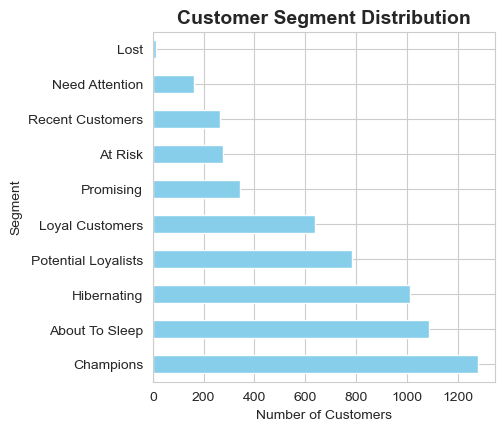

In [85]:
# 1. Customer Segment Distribution
ax1 = plt.subplot(2, 3, 1)
segment_counts.plot(kind='barh', color='skyblue', ax=ax1)
ax1.set_title('Customer Segment Distribution', fontsize=14, fontweight='bold')
ax1.set_xlabel('Number of Customers')
ax1.set_ylabel('Segment')

Text(0, 0.5, 'Frequency')

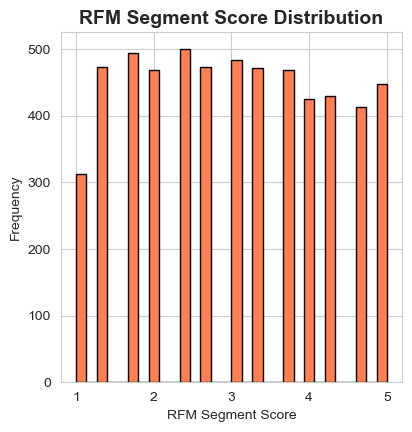

In [86]:
# 2. RFM Score Distribution
ax2 = plt.subplot(2, 3, 2)
rfm['RFM_Segment_Score'].hist(bins=30, color='coral', edgecolor='black', ax=ax2)
ax2.set_title('RFM Segment Score Distribution', fontsize=14, fontweight='bold')
ax2.set_xlabel('RFM Segment Score')
ax2.set_ylabel('Frequency')

Text(0, 0.5, 'Frequency')

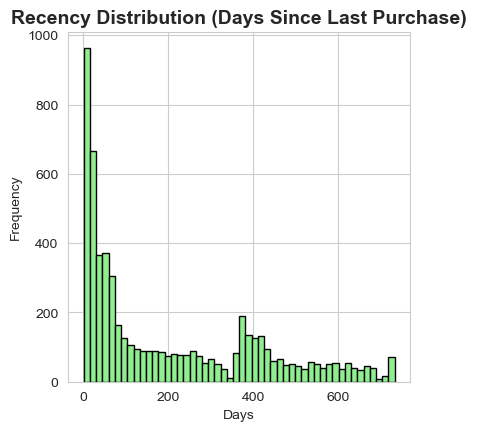

In [87]:
# 3. Recency Distribution
ax3 = plt.subplot(2, 3, 3)
rfm['Recency'].hist(bins=50, color='lightgreen', edgecolor='black', ax=ax3)
ax3.set_title('Recency Distribution (Days Since Last Purchase)', fontsize=14, fontweight='bold')
ax3.set_xlabel('Days')
ax3.set_ylabel('Frequency')

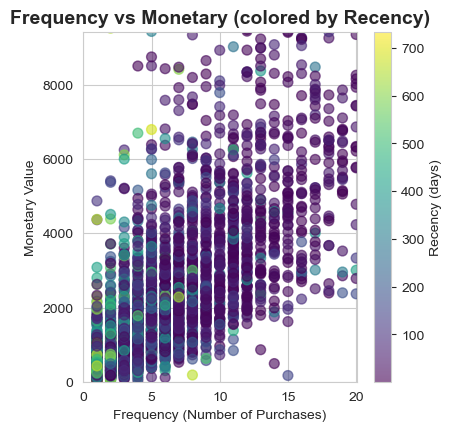

In [88]:
# 4. Frequency vs Monetary
ax4 = plt.subplot(2, 3, 4)
scatter = ax4.scatter(rfm['Frequency'], rfm['Monetary'], 
                     c=rfm['Recency'], cmap='viridis', alpha=0.6, s=50)
ax4.set_title('Frequency vs Monetary (colored by Recency)', fontsize=14, fontweight='bold')
ax4.set_xlabel('Frequency (Number of Purchases)')
ax4.set_ylabel('Monetary Value')
ax4.set_xlim(0, rfm['Frequency'].quantile(0.95))
ax4.set_ylim(0, rfm['Monetary'].quantile(0.95))
plt.colorbar(scatter, ax=ax4, label='Recency (days)')

Text(0, 0.5, 'Segment')

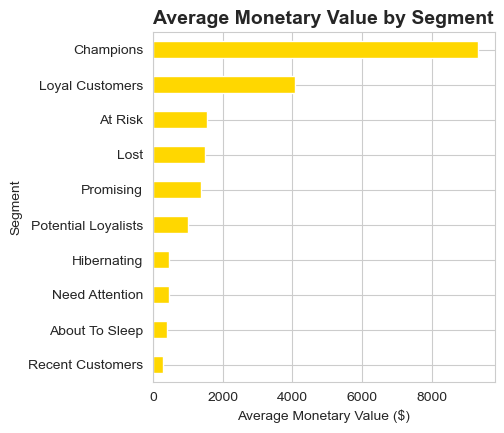

In [89]:
# 5. Segment by Average Monetary Value
ax5 = plt.subplot(2, 3, 5)
segment_monetary = rfm.groupby('Customer_Segment')['Monetary'].mean().sort_values()
segment_monetary.plot(kind='barh', color='gold', ax=ax5)
ax5.set_title('Average Monetary Value by Segment', fontsize=14, fontweight='bold')
ax5.set_xlabel('Average Monetary Value ($)')
ax5.set_ylabel('Segment')

Text(980.81045751634, 0.5, 'Recency Score')

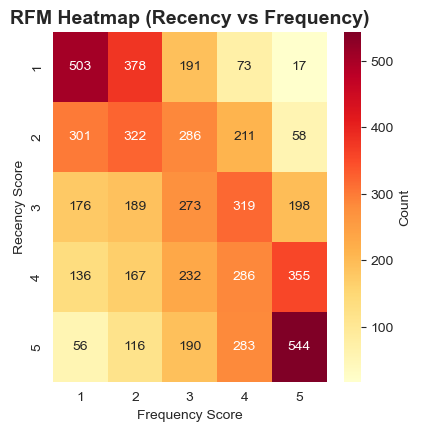

In [90]:
# 6. RFM Heatmap
ax6 = plt.subplot(2, 3, 6)
rfm_pivot = rfm.groupby(['R_score', 'F_score']).size().unstack(fill_value=0)
sns.heatmap(rfm_pivot, annot=True, fmt='d', cmap='YlOrRd', ax=ax6, cbar_kws={'label': 'Count'})
ax6.set_title('RFM Heatmap (Recency vs Frequency)', fontsize=14, fontweight='bold')
ax6.set_xlabel('Frequency Score')
ax6.set_ylabel('Recency Score')

In [91]:
plt.tight_layout()
plt.savefig('rfm_analysis_dashboard.png', dpi=300, bbox_inches='tight')
print("✓ Visualizations saved to 'rfm_analysis_dashboard.png'")

✓ Visualizations saved to 'rfm_analysis_dashboard.png'


<Figure size 1500x1000 with 0 Axes>

✓ Pie chart saved to 'segment_distribution_pie.png'


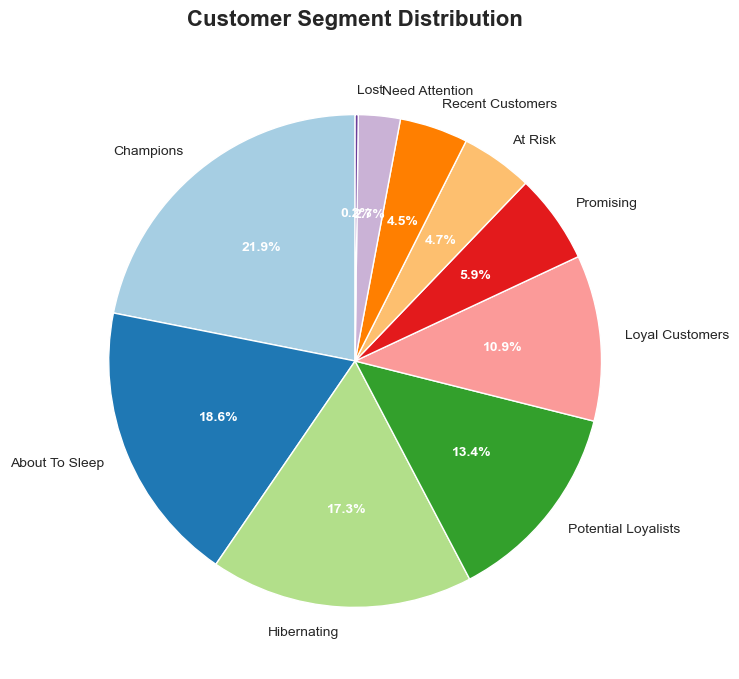

In [92]:
# Create Segment Distribution Pie Chart
fig2, ax = plt.subplots(figsize=(12, 8))
colors = plt.cm.Paired(range(len(segment_counts)))
wedges, texts, autotexts = ax.pie(segment_counts, labels=segment_counts.index, 
                                    autopct='%1.1f%%', colors=colors, startangle=90)
ax.set_title('Customer Segment Distribution', fontsize=16, fontweight='bold', pad=20)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
plt.savefig('segment_distribution_pie.png', dpi=300, bbox_inches='tight')
print("✓ Pie chart saved to 'segment_distribution_pie.png'")

plt.show()

## Key Insights and Recommendation

## 📊 BUSINESS INSIGHTS

In [93]:
# Top segments
top_segment = segment_summary.index[0]
print(f"\n1. Top Customer Segment: {top_segment}")
print(f"   - Count: {segment_summary.loc[top_segment, 'CustomerCount']} customers")
print(f"   - Avg Monetary Value: ${segment_summary.loc[top_segment, 'Avg_Monetary']:.2f}")


1. Top Customer Segment: About To Sleep
   - Count: 1088 customers
   - Avg Monetary Value: $401.14


In [78]:
# Champions analysis
if 'Champions' in rfm['Customer_Segment'].values:
    champions = rfm[rfm['Customer_Segment'] == 'Champions']
    print(f"\n2. Champions Segment:")
    print(f"   - Total: {len(champions)} customers ({len(champions)/len(rfm)*100:.1f}%)")
    print(f"   - Total Revenue: ${champions['Monetary'].sum():,.2f}")
    print(f"   - Revenue Contribution: {champions['Monetary'].sum()/rfm['Monetary'].sum()*100:.1f}%")


2. Champions Segment:
   - Total: 1282 customers (21.9%)
   - Total Revenue: $11,960,790.43
   - Revenue Contribution: 69.0%


In [79]:
# At Risk analysis
if 'At Risk' in rfm['Customer_Segment'].values:
    at_risk = rfm[rfm['Customer_Segment'] == 'At Risk']
    print(f"\n3. At Risk Customers:")
    print(f"   - Total: {len(at_risk)} customers")
    print(f"   - Potential Revenue Loss: ${at_risk['Monetary'].sum():,.2f}")


3. At Risk Customers:
   - Total: 277 customers
   - Potential Revenue Loss: $428,632.99


## Recommendations

In [94]:
print("""
1. CHAMPIONS (High R, F, M):
   → Reward with loyalty programs and exclusive offers
   → Turn them into brand advocates
   → Early access to new products

2. LOYAL CUSTOMERS:
   → Upsell and cross-sell premium products
   → Offer membership benefits
   → Personalized recommendations

3. AT RISK (High F, M but low R):
   → Win-back campaigns with special discounts
   → Re-engagement emails
   → Personalized "We miss you" offers

4. HIBERNATING/LOST:
   → Low-cost re-engagement campaigns
   → Survey to understand why they left
   → Consider removing from active marketing

5. RECENT CUSTOMERS:
   → Onboarding campaigns
   → Build engagement with educational content
   → First-purchase follow-ups
""")


1. CHAMPIONS (High R, F, M):
   → Reward with loyalty programs and exclusive offers
   → Turn them into brand advocates
   → Early access to new products

2. LOYAL CUSTOMERS:
   → Upsell and cross-sell premium products
   → Offer membership benefits
   → Personalized recommendations

3. AT RISK (High F, M but low R):
   → Win-back campaigns with special discounts
   → Re-engagement emails
   → Personalized "We miss you" offers

4. HIBERNATING/LOST:
   → Low-cost re-engagement campaigns
   → Survey to understand why they left
   → Consider removing from active marketing

5. RECENT CUSTOMERS:
   → Onboarding campaigns
   → Build engagement with educational content
   → First-purchase follow-ups

